# Usage (quick version)

## Preparation

In [1]:
# Standard users
# !pip install covsirphy
# Developers (Note: this notebook is in example directory)
import os
os.chdir("../")

In [2]:
import covsirphy as cs
cs.__version__

'2.5.4'

## Dataset preparation
Download the datasets to "input" direcotry and load them.

If "input" directory has the datasets, `DataLoader` will load the local files. If the datasets were updated in remote servers, `DataLoader` will update the local files automatically.
Download the datasets to "input" direcotry and load them.

If "input" directory has the datasets, `DataLoader` will load the local files. If the datasets were updated in remote servers, `DataLoader` will update the local files automatically.

In [3]:
data_loader = cs.DataLoader("input")
# The number of cases (JHU style)
jhu_data = data_loader.jhu(verbose=True)
# Population in each country
population_data = data_loader.population(verbose=True)
# Government Response Tracker (OxCGRT)
oxcgrt_data = data_loader.oxcgrt(verbose=True)

### The number of cases (JHU style)

In [4]:
# Description/citation
print(jhu_data.citation)

(Secondary source) Guidotti, E., Ardia, D., (2020), "COVID-19 Data Hub", Working paper, doi: 10.13140/RG.2.2.11649.81763.
We can get Citation list of primary sources with DataLoader(...).covid19dh_citation

In [5]:
print(data_loader.covid19dh_citation)

Australian Bureau of Statistics (2019), https://www.abs.gov.au/
CIA - Central Intelligence Agency (2018), https://www.cia.gov/
CIA - Central Intelligence Agency (2019), https://www.cia.gov/
CIA - Central Intelligence Agency (2020), https://www.cia.gov/
COVID-19 Peru Data Repository (2020), https://github.com/
COVID-19 Turkey API (2020), https://github.com/
COVID-19_plus_Russia GitHub repository (2020), https://github.com/
COVID19-India API (2020), https://www.covid19india.org/
Canada's National Statistical Agency (2020), https://www150.statcan.gc.ca/
Centre of Excellence in Economics and Data Science, University of Milano (2020), https://github.com/
Covid19data.com.au (2020), https://github.com/
Czech Statistical Office (2018), https://www.czso.cz/
Data Science for Social Impact research group, University of Pretoria (2020), https://github.com/
Epistat, Belgian Infectious Diseases (2020), https://epistat.sciensano.be/
Eurostat (2019), https://ec.europa.eu/
Geloky (2019), https://geloky

In [6]:
# Raw data
jhu_data.raw.tail()

,ObservationDate,Confirmed,Recovered,Deaths,Population,ISO3,Province/State,Country/Region,school_closing,workplace_closing,cancel_events,gatherings_restrictions,transport_closing,stay_home_restrictions,internal_movement_restrictions,international_movement_restrictions,information_campaigns,testing_policy,contact_tracing,stringency_index
151997,2020-07-14,1,1,0,107808.0,COL,Vichada,Colombia,3,2,2,4,1,2,2,4,2,2,2,87.04
151998,2020-07-15,1,1,0,107808.0,COL,Vichada,Colombia,3,2,2,4,1,2,2,4,2,2,2,87.04
151999,2020-07-16,1,1,0,107808.0,COL,Vichada,Colombia,3,2,2,4,1,2,2,4,2,2,2,87.04
152000,2020-07-17,1,1,0,107808.0,COL,Vichada,Colombia,3,2,2,4,1,2,2,4,2,2,2,87.04
152001,2020-07-18,1,1,0,107808.0,COL,Vichada,Colombia,3,2,2,4,1,2,2,4,2,2,2,87.04


In [7]:
# Cleaned data
jhu_data.cleaned().tail()

,Date,Country,Province,Confirmed,Infected,Fatal,Recovered
151997,2020-07-14,Colombia,Vichada,1,0,0,1
151998,2020-07-15,Colombia,Vichada,1,0,0,1
151999,2020-07-16,Colombia,Vichada,1,0,0,1
152000,2020-07-17,Colombia,Vichada,1,0,0,1
152001,2020-07-18,Colombia,Vichada,1,0,0,1


In [8]:
# Subset for a country
jhu_data.subset("Japan", province="Tokyo").tail()

,Date,Confirmed,Infected,Fatal,Recovered
181,2020-07-14,8189,1528,325,6336
182,2020-07-15,8354,1556,326,6472
183,2020-07-16,8640,1706,326,6608
184,2020-07-17,8933,1836,326,6771
185,2020-07-18,9223,2126,326,6771


In [9]:
# Total
total_df = jhu_data.total()
total_df.tail()

,Confirmed,Infected,Fatal,Recovered,Fatal per Confirmed,Recovered per Confirmed,Fatal per (Fatal or Recovered)
Date,,,,,,,
2020-07-14,20397766,10037302,857557,9502907,0.042042,0.465880,0.082772
2020-07-15,20724121,10145641,864931,9713549,0.041735,0.468707,0.081763
2020-07-16,21105816,10325162,872630,9908024,0.041345,0.469445,0.080944
2020-07-17,21471390,10441836,881083,10148471,0.041035,0.472651,0.079884
2020-07-18,21472139,10461510,881083,10129546,0.041034,0.471753,0.080021


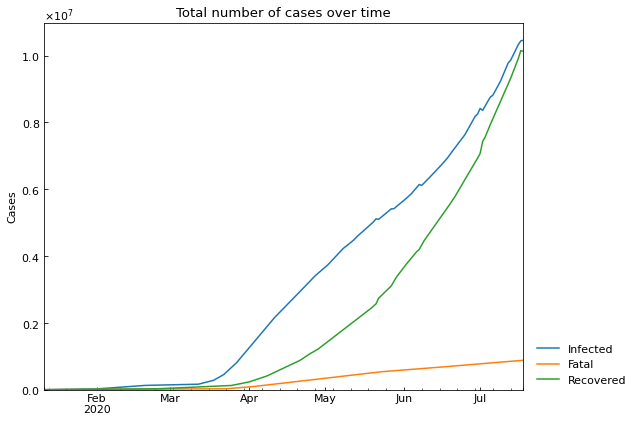

In [10]:
# Plot the total values
cs.line_plot(total_df[["Infected", "Fatal", "Recovered"]], "Total number of cases over time")

### (Optional) Replace the dataset in Japan


In [11]:
jhu_data.subset("Japan").tail()

,Date,Confirmed,Infected,Fatal,Recovered
184,2020-07-13,22197,3114,983,18100
185,2020-07-14,22530,3271,983,18276
186,2020-07-15,22982,3460,984,18538
187,2020-07-16,23604,3811,984,18809
188,2020-07-17,24201,4126,984,19091


In [12]:
japan_data = data_loader.japan()
print(japan_data.citation)

Lisphilar (2020), COVID-19 dataset in Japan, GitHub repository, https://github.com/lisphilar/covid19-sir/data/japan

In [13]:
jhu_data.replace(japan_data)
jhu_data.subset("Japan").tail()

,Date,Confirmed,Infected,Fatal,Recovered
152,2020-07-12,21502,2517,982,18003
153,2020-07-13,21868,2783,982,18103
154,2020-07-14,22220,2956,982,18282
155,2020-07-15,22508,2979,984,18545
156,2020-07-16,22890,3091,985,18814


### Population in each country

In [14]:
# Description/citation
print(population_data.citation)

(Secondary source) Guidotti, E., Ardia, D., (2020), "COVID-19 Data Hub", Working paper, doi: 10.13140/RG.2.2.11649.81763.
We can get Citation list of primary sources with DataLoader(...).covid19dh_citation

In [15]:
# Raw data (the same as jhu_data)
population_data.raw.tail()

,ObservationDate,Confirmed,Recovered,Deaths,Population,ISO3,Province/State,Country/Region,school_closing,workplace_closing,cancel_events,gatherings_restrictions,transport_closing,stay_home_restrictions,internal_movement_restrictions,international_movement_restrictions,information_campaigns,testing_policy,contact_tracing,stringency_index
151997,2020-07-14,1,1,0,107808.0,COL,Vichada,Colombia,3,2,2,4,1,2,2,4,2,2,2,87.04
151998,2020-07-15,1,1,0,107808.0,COL,Vichada,Colombia,3,2,2,4,1,2,2,4,2,2,2,87.04
151999,2020-07-16,1,1,0,107808.0,COL,Vichada,Colombia,3,2,2,4,1,2,2,4,2,2,2,87.04
152000,2020-07-17,1,1,0,107808.0,COL,Vichada,Colombia,3,2,2,4,1,2,2,4,2,2,2,87.04
152001,2020-07-18,1,1,0,107808.0,COL,Vichada,Colombia,3,2,2,4,1,2,2,4,2,2,2,87.04


In [16]:
# Cleaned data
population_data.cleaned().tail()

,ISO3,Country,Province,Population
808,CZE,Czech Republic,Plzenský kraj,584672
809,COL,Colombia,Bolívar,2070110
810,RUS,Russia,Murmansk oblast,795409
811,RUS,Russia,Republic of Crimea,1913731
812,COL,Colombia,Vichada,107808


In [17]:
population_data.value("Japan", province=None)

126529100

In [18]:
# Register population value of Tokyo in Japan
# https://www.metro.tokyo.lg.jp/tosei/hodohappyo/press/2020/06/11/07.html
population_data.update(14_002_973, "Japan", province="Tokyo")
population_data.value("Japan", province="Tokyo")

14002973

### Government Response Tracker (OxCGRT)

In [19]:
# Description/citation
print(oxcgrt_data.citation)

(Secondary source) Guidotti, E., Ardia, D., (2020), "COVID-19 Data Hub", Working paper, doi: 10.13140/RG.2.2.11649.81763.
We can get Citation list of primary sources with DataLoader(...).covid19dh_citation

In [20]:
# Raw data (the same as jhu_data)
oxcgrt_data.raw.tail()

,ObservationDate,Confirmed,Recovered,Deaths,Population,ISO3,Province/State,Country/Region,school_closing,workplace_closing,cancel_events,gatherings_restrictions,transport_closing,stay_home_restrictions,internal_movement_restrictions,international_movement_restrictions,information_campaigns,testing_policy,contact_tracing,stringency_index
151997,2020-07-14,1,1,0,107808.0,COL,Vichada,Colombia,3,2,2,4,1,2,2,4,2,2,2,87.04
151998,2020-07-15,1,1,0,107808.0,COL,Vichada,Colombia,3,2,2,4,1,2,2,4,2,2,2,87.04
151999,2020-07-16,1,1,0,107808.0,COL,Vichada,Colombia,3,2,2,4,1,2,2,4,2,2,2,87.04
152000,2020-07-17,1,1,0,107808.0,COL,Vichada,Colombia,3,2,2,4,1,2,2,4,2,2,2,87.04
152001,2020-07-18,1,1,0,107808.0,COL,Vichada,Colombia,3,2,2,4,1,2,2,4,2,2,2,87.04


In [21]:
# Cleaned data
oxcgrt_data.cleaned().tail()

,Date,Country,ISO3,School_closing,Workplace_closing,Cancel_events,Gatherings_restrictions,Transport_closing,Stay_home_restrictions,Internal_movement_restrictions,International_movement_restrictions,Information_campaigns,Testing_policy,Contact_tracing,Stringency_index
151997,2020-07-14,Colombia,COL,3,2,2,4,1,2,2,4,2,2,2,87.04
151998,2020-07-15,Colombia,COL,3,2,2,4,1,2,2,4,2,2,2,87.04
151999,2020-07-16,Colombia,COL,3,2,2,4,1,2,2,4,2,2,2,87.04
152000,2020-07-17,Colombia,COL,3,2,2,4,1,2,2,4,2,2,2,87.04
152001,2020-07-18,Colombia,COL,3,2,2,4,1,2,2,4,2,2,2,87.04


In [22]:
# Subset for a country
oxcgrt_data.subset(country="Japan").tail()

,Date,School_closing,Workplace_closing,Cancel_events,Gatherings_restrictions,Transport_closing,Stay_home_restrictions,Internal_movement_restrictions,International_movement_restrictions,Information_campaigns,Testing_policy,Contact_tracing,Stringency_index
185,2020-07-14,2,0,1,0,0,0,0,3,2,2,1,27.78
186,2020-07-15,2,0,1,0,0,0,0,3,2,2,1,27.78
187,2020-07-16,2,0,1,0,0,0,0,3,2,2,1,27.78
188,2020-07-17,2,0,1,0,0,0,0,3,2,2,1,27.78
189,2020-07-18,2,0,1,0,0,0,0,3,2,2,1,27.78


In [23]:
# Subset for a country (using ISO3 code)
oxcgrt_data.subset(iso3="JPN").tail()

,Date,School_closing,Workplace_closing,Cancel_events,Gatherings_restrictions,Transport_closing,Stay_home_restrictions,Internal_movement_restrictions,International_movement_restrictions,Information_campaigns,Testing_policy,Contact_tracing,Stringency_index
185,2020-07-14,2,0,1,0,0,0,0,3,2,2,1,27.78
186,2020-07-15,2,0,1,0,0,0,0,3,2,2,1,27.78
187,2020-07-16,2,0,1,0,0,0,0,3,2,2,1,27.78
188,2020-07-17,2,0,1,0,0,0,0,3,2,2,1,27.78
189,2020-07-18,2,0,1,0,0,0,0,3,2,2,1,27.78


## Scenario analysis
As an example, we will analysis the number of cases in Japan.

In [24]:
scenario = cs.Scenario(jhu_data, population_data, country="Japan", province=None)

### Check records

/mnt/c/Users/takay/Documents/github/covid19-sir/.venv/lib/python3.8/site-packages/pandas/plotting/_matplotlib/converter.py:256: MatplotlibDeprecationWarning: 
The epoch2num function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  base = dates.epoch2num(dt.asi8 / 1.0e9)


/mnt/c/Users/takay/Documents/github/covid19-sir/.venv/lib/python3.8/site-packages/pandas/plotting/_matplotlib/converter.py:256: MatplotlibDeprecationWarning: 
The epoch2num function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  base = dates.epoch2num(dt.asi8 / 1.0e9)


/mnt/c/Users/takay/Documents/github/covid19-sir/.venv/lib/python3.8/site-packages/pandas/plotting/_matplotlib/converter.py:256: MatplotlibDeprecationWarning: 
The epoch2num function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  base = dates.epoch2num(dt.asi8 / 1.0e9)


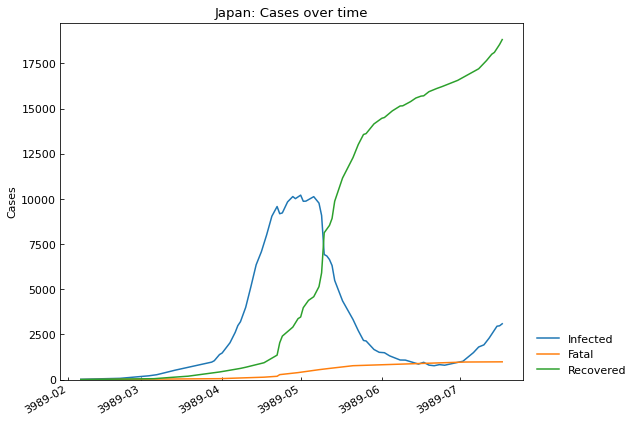

,Date,Confirmed,Infected,Fatal,Recovered
152,2020-07-12,21502,2517,982,18003
153,2020-07-13,21868,2783,982,18103
154,2020-07-14,22220,2956,982,18282
155,2020-07-15,22508,2979,984,18545
156,2020-07-16,22890,3091,985,18814


In [25]:
record_df = scenario.records()
record_df.tail()

### S-R trend analysis

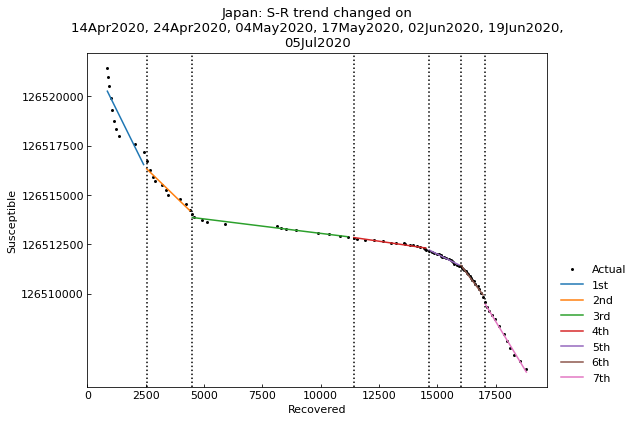

,Type,Start,End,Population
1st,Past,14Apr2020,23Apr2020,126529100
2nd,Past,24Apr2020,03May2020,126529100
3rd,Past,04May2020,16May2020,126529100
4th,Past,17May2020,01Jun2020,126529100
5th,Past,02Jun2020,18Jun2020,126529100
6th,Past,19Jun2020,04Jul2020,126529100
7th,Past,05Jul2020,16Jul2020,126529100


In [26]:
scenario.trend(set_phases=True)
scenario.summary()

### Hyperparameter estimation of ODE models
As an example, use SIR-F model.
We can use SIR, SIRD, (SIRFV), (SEWIRF).

In [27]:
scenario.estimate(cs.SIRF)


<Main scenario: perform parameter estimation>

Running optimization with 8 CPUs...

	7th phase with SIR-F model finished 207 trials in 0 min 25 sec.

	1st phase with SIR-F model finished 449 trials in 1 min 1 sec.

	2nd phase with SIR-F model finished 404 trials in 1 min 1 sec.

	4th phase with SIR-F model finished 180 trials in 0 min 30 sec.

	3rd phase with SIR-F model finished 339 trials in 0 min 56 sec.

	5th phase with SIR-F model finished 187 trials in 0 min 30 sec.

	6th phase with SIR-F model finished 338 trials in 0 min 35 sec.

Completed optimization. Total: 2 min 33 sec

In [28]:
scenario.summary()

,Type,Start,End,Population,ODE,rho,sigma,theta,kappa,tau,Rt,alpha1 [-],1/alpha2 [day],1/beta [day],1/gamma [day],RMSLE,Trials,Runtime
1st,Past,14Apr2020,23Apr2020,126529100,SIR-F,0.003569,0.000621,0.021079,0.000046,96,5.24,0.021,1455,18,107,0.149257,449,1 min 1 sec
2nd,Past,24Apr2020,03May2020,126529100,SIR-F,0.001437,0.001142,0.198540,0.000090,96,0.94,0.199,739,46,58,0.252791,404,1 min 1 sec
3rd,Past,04May2020,16May2020,126529100,SIR-F,0.000875,0.005405,0.224372,0.000048,96,0.12,0.224,1382,76,12,0.145436,339,0 min 56 sec
4th,Past,17May2020,01Jun2020,126529100,SIR-F,0.001119,0.005500,0.327122,0.000002,96,0.14,0.327,36000,59,12,0.082161,180,0 min 30 sec
5th,Past,02Jun2020,18Jun2020,126529100,SIR-F,0.002914,0.004812,0.296103,0.000071,96,0.42,0.296,937,22,13,0.128377,187,0 min 30 sec
6th,Past,19Jun2020,04Jul2020,126529100,SIR-F,0.006290,0.004063,0.071881,0.000199,96,1.37,0.072,334,10,16,0.077767,338,0 min 35 sec
7th,Past,05Jul2020,16Jul2020,126529100,SIR-F,0.009759,0.004963,0.004991,0.000130,96,1.91,0.005,514,6,13,0.036399,207,0 min 25 sec


### Accuracy of estimation

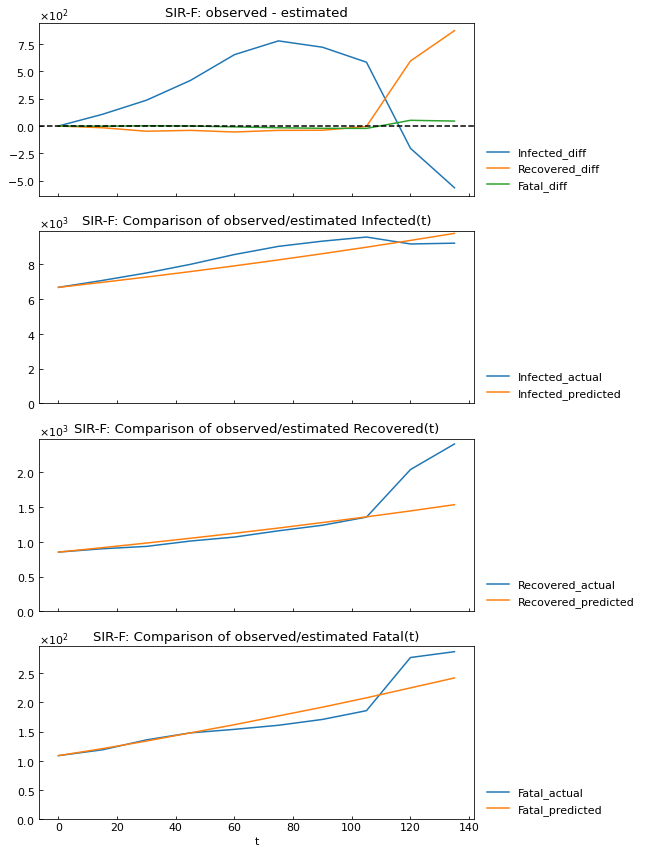

In [29]:
scenario.estimate_accuracy(phase="1st")

### Get parameter value

In [30]:
scenario.get("Rt", phase="4th")

0.14

### Show parameter history

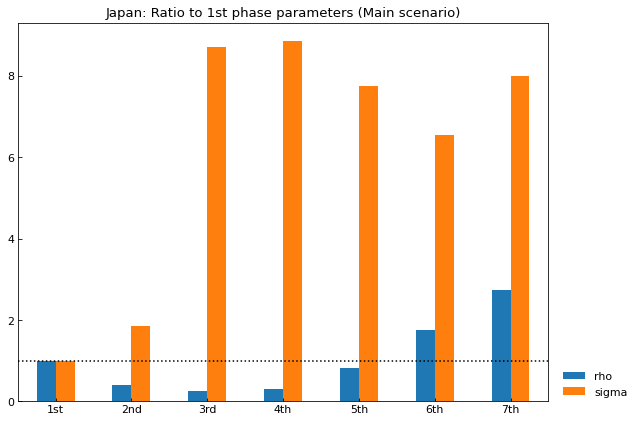

,1st,2nd,3rd,4th,5th,6th,7th
rho,1.0,0.402685,0.245196,0.313384,0.816463,1.762208,2.733932
sigma,1.0,1.840107,8.711242,8.863818,7.755493,6.547395,7.998020


In [31]:
df = scenario.param_history(targets=["rho", "sigma"])
df.T

### Show the history of reproduction number

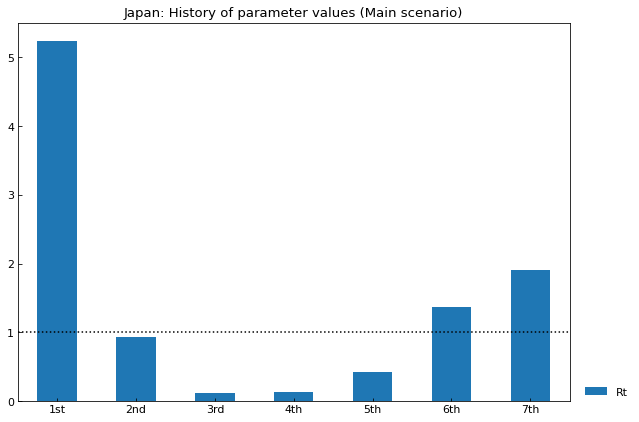

,1st,2nd,3rd,4th,5th,6th,7th
Rt,5.24,0.94,0.12,0.14,0.42,1.37,1.91


In [32]:
df = scenario.param_history(targets=["Rt"], divide_by_first=False, show_box_plot=True)
df.T

### Simulate the number of cases

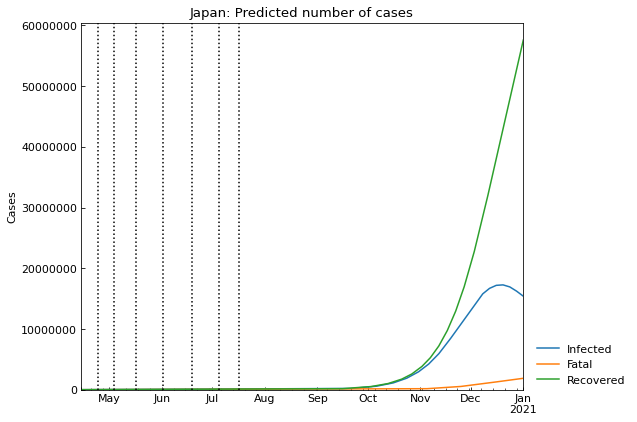

,Date,Fatal,Infected,Recovered,Susceptible
258,28Dec2020,1752787,16234471,53416372,55125469
259,29Dec2020,1789230,16016470,54616890,54106510
260,30Dec2020,1825070,15783164,55800602,53120263
261,31Dec2020,1860280,15535892,56966419,52166508
262,01Jan2021,1878822,15399263,57581329,51669687


In [33]:
scenario.clear(name="Main")
scenario.add_phase(name="Main", end_date="01Jan2021")
main_sim_df = scenario.simulate(name="Main")
main_sim_df.tail()

### Simulate another scenario
If $\sigma$ will be double in 30 days, how many cases will be?

In [34]:
sigma_current = scenario.get("sigma", name="Main", phase="last")
sigma_current

0.004962832493308578

In [35]:
sigma_new = sigma_current * 2
sigma_new

0.009925664986617157

In [36]:
scenario.clear(name="Medicine")
scenario.add_phase(name="Medicine", days=30, sigma=sigma_current)
scenario.add_phase(name="Medicine", end_date="01Jan2021", sigma=sigma_new)
scenario.summary()

Type      Start        End  Population    ODE       rho  \
Scenario Phase                                                              
Main     1st      Past  14Apr2020  23Apr2020   126529100  SIR-F  0.003569   
         2nd      Past  24Apr2020  03May2020   126529100  SIR-F  0.001437   
         3rd      Past  04May2020  16May2020   126529100  SIR-F  0.000875   
         4th      Past  17May2020  01Jun2020   126529100  SIR-F  0.001119   
         5th      Past  02Jun2020  18Jun2020   126529100  SIR-F  0.002914   
         6th      Past  19Jun2020  04Jul2020   126529100  SIR-F  0.006290   
         7th      Past  05Jul2020  16Jul2020   126529100  SIR-F  0.009759   
         8th    Future  17Jul2020  01Jan2021   126529100  SIR-F  0.009759   
Medicine 1st      Past  14Apr2020  23Apr2020   126529100  SIR-F  0.003569   
         2nd      Past  24Apr2020  03May2020   126529100  SIR-F  0.001437   
         3rd      Past  04May2020  16May2020   126529100  SIR-F  0.000875   
         4th      Past  17May2020  01Jun2020   126529100  SIR-F  0.001119   
         5th      Past  02Jun2020  18Jun2020   126529100  SIR-F  0.002914   
         6th      Past  19Jun2020  04Jul2020   126529100  SIR-F  0.006290   
         7th      Past  05Jul2020  16Jul2020   126529100  SIR-F  0.009759   
         8th    Future  17Jul2020  16Aug2020   126529100  SIR-F  0.009759   
         9th    Future  17Aug2020  01Jan2021   126529100  SIR-F  0.009759   

                   sigma     theta     kappa  tau    Rt  alpha1 [-]  \
Scenario Phase                                                        
Main     1st    0.000621  0.021079  0.000046   96  5.24       0.021   
         2nd    0.001142  0.198540  0.000090   96  0.94       0.199   
         3rd    0.005405  0.224372  0.000048   96  0.12       0.224   
         4th    0.005500  0.327122  0.000002   96  0.14       0.327   
         5th    0.004812  0.296103  0.000071   96  0.42       0.296   
         6th    0.004063  0.071881  0.000199   96  1.37       0.072   
         7th    0.004963  0.004991  0.000130   96  1.91       0.005   
         8th    0.004963  0.004991  0.000130   96  1.91       0.005   
Medicine 1st    0.000621  0.021079  0.000046   96  5.24       0.021   
         2nd    0.001142  0.198540  0.000090   96  0.94       0.199   
         3rd    0.005405  0.224372  0.000048   96  0.12       0.224   
         4th    0.005500  0.327122  0.000002   96  0.14       0.327   
         5th    0.004812  0.296103  0.000071   96  0.42       0.296   
         6th    0.004063  0.071881  0.000199   96  1.37       0.072   
         7th    0.004963  0.004991  0.000130   96  1.91       0.005   
         8th    0.004963  0.004991  0.000130   96  1.91       0.005   
         9th    0.009926  0.004991  0.000130   96  0.97       0.005   

                1/alpha2 [day]  1/beta [day]  1/gamma [day]      RMSLE Trials  \
Scenario Phase                                                                  
Main     1st              1455            18            107   0.149257    449   
         2nd               739            46             58   0.252791    404   
         3rd              1382            76             12   0.145436    339   
         4th             36000            59             12  0.0821609    180   
         5th               937            22             13   0.128377    187   
         6th               334            10             16   0.077767    338   
         7th               514             6             13  0.0363994    207   
         8th               514             6             13          -      -   
Medicine 1st              1455            18            107   0.149257    449   
         2nd               739            46             58   0.252791    404   
         3rd              1382            76             12   0.145436    339   
         4th             36000            59             12  0.0821609    180   
         5th               937            22             13   0.128377

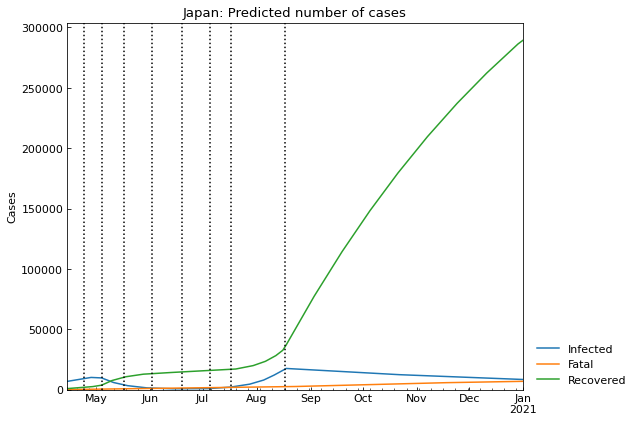

,Date,Fatal,Infected,Recovered,Susceptible
258,28Dec2020,6859,8619,285122,126228500
259,29Dec2020,6882,8572,286401,126227245
260,30Dec2020,6905,8525,287674,126225996
261,31Dec2020,6928,8478,288940,126224755
262,01Jan2021,6940,8453,289613,126224096


In [37]:
scenario.simulate(name="Medicine").tail()

### Compare the scenarios

In [38]:
scenario.describe()

,max(Infected),argmax(Infected),Infected on 01Jan2021,Fatal on 01Jan2021
Main,17281975,19Dec2020,15399263,1878822
Medicine,17682,17Aug2020,8453,6940
